## Importing required libraries

In [1]:
import sys
sys.path.append('/home/aistudio/external-libraries')

import jax
import jax.numpy as jnp
import jax.random as random

import time
import math
import numpy as np
import pandas as pd

import optax
import jaxopt
import matplotlib.pyplot as plt
from matplotlib import font_manager
import matplotlib.gridspec as gridspec
from typing import Tuple

import scipy.io
from scipy.stats import qmc
from scipy.special import factorial
jax.config.update("jax_enable_x64", True)

font_path = '/home/aistudio/Times_New_Roman.ttf'
prop = font_manager.FontProperties(fname=font_path)

## Config for solving DDE

In [2]:
config = {
    "real_lag": [4., 2.],
    "init_lag": [0., 0.],
    "tmin": 0.,
    "tmax": 10.,
    "initial_key": 0,
    "noise_level": 0.,
    "conds": [0., 5., 1., 0.],
    "netLayers": [1, 20, 40, 20, 1],
    "record_info": False,
    "gap": 500,
    "N_f": 5000,
    "N_g": 20,
    "loss_threshold": 1e-10,
    "step_epochs": [10000, 2001],
    "initial_lr" : 1e-3,
    "cosine_decay_steps": 1000,
    "cosine_alpha": 0.01,
    "given_data_root_path": "/home/aistudio/DDE_2rd_revision/data/ex4.4.2",
    "result_save_path": "/home/aistudio/DDE_2rd_revision/result/ex4.4.2"
}

In [3]:
# # Retrieve the variable 'config' from IPython's storage space
# %store -r config

## Defining the System of Delay Differential Equation
Consider the system of delay differential equations with two unknown delays on the solution interval $[0,10]$:
\begin{equation}
    \begin{cases}
        \begin{aligned}\dot{S}(t) &= -\beta \cdot S(t) \cdot I(t-\tau_2) + \gamma \cdot I(t-\tau_1), \quad t \geq 0, \\\dot{I}(t) &= \beta \cdot S(t) \cdot I(t-\tau_2) - \alpha \cdot  I(t), \quad t \geq 0, \\\dot{R}(t) &= \alpha \cdot I(t) - \gamma \cdot I(t-\tau_1), \quad t \geq 0.\end{aligned}
    \end{cases}
\end{equation}

The initial conditions are given by

\begin{equation}
    [S(0), I(0), R(0)] = [5, 1, 0].
\end{equation}

The system parameters are given by

\begin{equation}
    [\alpha, \beta, \gamma] = [0.3, 0.7, 0.1].
\end{equation}

In [4]:
def DDEs(t, u, lag):
    beta, alpha, gamma = 0.7, 0.3, 0.1

    S = u(t)[0]
    I = u(t)[1]
    R = u(t)[2]

    rhs = [-beta * S * jnp.where(t > lag[1], u(t - lag[1])[1], 1) + gamma * jnp.where(t > lag[0], u(t - lag[0])[1], 1),
            beta * S * jnp.where(t > lag[1], u(t - lag[1])[1], 1) - alpha * I,
            alpha * I - gamma * jnp.where(t > lag[0], u(t - lag[0])[1], 1)
    ]

    tem_list = []

    for i in range(3):
        u_t = lambda t: jax.grad(lambda t: jnp.sum(u(t)[i]))(t)
        tem_i = u_t(t) - rhs[i]
        tem_list.append(tem_i.reshape(-1, 1))

    tem = jnp.hstack(tem_list)
    
    return tem

## Construct the DNNs and initialize parameters

In [5]:
# Define the DNNs model
def DNNs(params, x):
    for w, b in params[0:-1]:
        x = jnp.dot(x, w) + b
        x = jnp.tanh(x)

    w, b = params[-1]
    x = jnp.dot(x, w) + b
    return x

# Xavier initialization for the layer parameters
def random_layer_params_xavier(m, n, key):
    xavier_stddev = jnp.sqrt(2.0 / (m + n))

    w_key, b_key = jax.random.split(key)

    weights = xavier_stddev * jax.random.truncated_normal(
        w_key, lower=-2.0, upper=2.0, shape=(m, n)
    )
    biases = jnp.zeros((n,))

    return weights, biases

# Initialize parameters for all layers in a fully-connected neural network with the specified sizes
def init_network_params(sizes, key):
    keys = jax.random.split(key, len(sizes))
    return [random_layer_params_xavier(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

## Define the loss function

In [6]:
@jax.jit
def loss_fun1(params, inPoints, conds, init_data):
    lag = params[-1]
    t_c = inPoints[:, [0]]

    ufunc1 = lambda t: DNNs(params[0], t)
    ufunc2 = lambda t: DNNs(params[1], t)
    ufunc3 = lambda t: DNNs(params[2], t)

    def u(t):
        return [ufunc1(t), ufunc2(t), ufunc3(t)]

    # Differential equation residual losses
    res = DDEs(t_c, u, lag)
    loss_f1 = jnp.mean((res[:, 0])**2)
    loss_f2 = jnp.mean((res[:, 1])**2)
    loss_f3 = jnp.mean((res[:, 2])**2)

    # Initial condition losses
    t_0, u1_0, u2_0, u3_0 = conds[:, [0]], conds[:, [1]], conds[:, [2]], conds[:, [3]]
    loss_i1 = jnp.mean((ufunc1(t_0) - u1_0)**2)
    loss_i2 = jnp.mean((ufunc2(t_0) - u2_0)**2)
    loss_i3 = jnp.mean((ufunc3(t_0) - u3_0)**2)

    # Calculate the loss due to known data points
    t_1, u_1 = init_data[:,0].reshape(-1,1), init_data[:,1].reshape(-1,1)
    loss_g1 = jnp.mean((u_1 - ufunc1(t_1))**2)

    t_2, u_2 = init_data[:,2].reshape(-1,1), init_data[:,3].reshape(-1,1)
    loss_g2 = jnp.mean((u_2 - ufunc2(t_2))**2)

    t_3, u_3 = init_data[:,4].reshape(-1,1), init_data[:,5].reshape(-1,1)
    loss_g3 = jnp.mean((u_3 - ufunc3(t_3))**2)

    # Compute the sum of loss from all components
    loss_sum = loss_f1 + loss_f2 + loss_f3 + loss_i1 + loss_i2 + loss_i3 + loss_g1 + loss_g2 + loss_g3

    # Gather all loss terms
    all_losses = jnp.array([loss_f1, loss_f2, loss_f3, loss_i1, loss_i2, loss_i3, loss_g1, loss_g2, loss_g3])
    total_loss = jnp.sum(all_losses)

    # Dynamic weights
    weights = all_losses / total_loss

    # Weighted total loss
    loss_weighted = jnp.sum(all_losses * weights)

    return loss_weighted, all_losses


@jax.jit
def loss_fun2(params, inPoints, conds, init_data, initial_weights):
    lag = params[-1]
    t_c = inPoints[:, [0]]

    ufunc1 = lambda t: DNNs(params[0], t)
    ufunc2 = lambda t: DNNs(params[1], t)
    ufunc3 = lambda t: DNNs(params[2], t)

    def u(t):
        return [ufunc1(t), ufunc2(t), ufunc3(t)]

    # Differential equation residual losses
    res = DDEs(t_c, u, lag)
    loss_f1 = jnp.mean((res[:, 0])**2)
    loss_f2 = jnp.mean((res[:, 1])**2)
    loss_f3 = jnp.mean((res[:, 2])**2)

    # Initial condition losses
    t_0, u1_0, u2_0, u3_0 = conds[:, [0]], conds[:, [1]], conds[:, [2]], conds[:, [3]]
    loss_i1 = jnp.mean((ufunc1(t_0) - u1_0)**2)
    loss_i2 = jnp.mean((ufunc2(t_0) - u2_0)**2)
    loss_i3 = jnp.mean((ufunc3(t_0) - u3_0)**2)

    # Calculate the loss due to known data points
    t_1, u_1 = init_data[:,0].reshape(-1,1), init_data[:,1].reshape(-1,1)
    loss_g1 = jnp.mean((u_1 - ufunc1(t_1))**2)

    t_2, u_2 = init_data[:,2].reshape(-1,1), init_data[:,3].reshape(-1,1)
    loss_g2 = jnp.mean((u_2 - ufunc2(t_2))**2)

    t_3, u_3 = init_data[:,4].reshape(-1,1), init_data[:,5].reshape(-1,1)
    loss_g3 = jnp.mean((u_3 - ufunc3(t_3))**2)

    # Gather all loss terms
    all_losses = jnp.array([loss_f1, loss_f2, loss_f3, loss_i1, loss_i2, loss_i3, loss_g1, loss_g2, loss_g3])
    total_loss = jnp.sum(all_losses)

    # Weighted total loss
    loss_weighted = jnp.sum(all_losses * initial_weights)

    return loss_weighted, all_losses

## Two-step neural network training

In [7]:
# First Step：Adam Optimizer
def train_adam(params, inPoints, conds, init_data, record_info, num_epochs, start_epoch=0, log_interval=100, print_interval=1000):
    phase_epochs = []
    phase_losses = []
    phase_loss_terms = []
    phase_lag = []

    scheduler = optax.cosine_decay_schedule(
        init_value=config['initial_lr'],
        decay_steps=config['cosine_decay_steps'],
        alpha=config['cosine_alpha']
    )
    optimizer = optax.adam(learning_rate=scheduler)
    opt_state = optimizer.init(params)

    @jax.jit
    def update_adam(params, inPoints, conds, init_data, opt_state):
        (loss, all_losses), grads = jax.value_and_grad(loss_fun1, has_aux=True)(
            params, inPoints, conds, init_data
        )
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state, (loss, all_losses)

    if record_info:
        for epoch in range(num_epochs):
            params, opt_state, (loss, all_losses) = update_adam(
                params, inPoints, conds, init_data, opt_state
            )
            current_epoch = start_epoch + epoch

            if record_info and current_epoch % log_interval == 0:
                phase_epochs.append(current_epoch)
                phase_losses.append(loss)
                phase_loss_terms.append(all_losses)
                phase_lag.append(params[-1])

            if record_info and current_epoch % print_interval == 0:
                print(f"Epoch {current_epoch}, Total Loss: {loss:.3e}")
        
        return params, phase_epochs, phase_losses, phase_loss_terms, phase_lag, all_losses
    else:
        now_epoch = 0
        while now_epoch < num_epochs:
            params, opt_state, (loss, all_losses) = update_adam(
                params, inPoints, conds, init_data, opt_state
            )
            now_epoch += 1
        return params, None, None, None, None, all_losses


# Second Step：L-BFGS Optimizer
def train_lbfgs(params, inPoints, conds, init_data, initial_weights,
                record_info, num_epochs=10000, gap=100, start_epoch=0):

    phase_epochs = []
    phase_losses = []
    phase_loss_terms = []
    phase_lag = []

    current_params = params

    if record_info:
        solver = jaxopt.BFGS(
            fun=loss_fun2,
            tol=1e-16,
            maxiter=gap,
            has_aux=True,
            verbose=False
        )

        for epoch in range(start_epoch, start_epoch + num_epochs + 1, gap):
            sol = solver.run(current_params, inPoints, conds, init_data, initial_weights)
            current_params = sol.params
            loss, all_losses = sol.state.value, sol.state.aux

            phase_losses.append(loss)
            phase_loss_terms.append(all_losses)
            phase_epochs.append(epoch + gap)
            phase_lag.append(current_params[-1])

            print(f"Epoch {epoch+gap}, Total Loss: {loss:.3e}, Lag: {current_params[-1]}")

        return current_params, phase_epochs, phase_losses, phase_loss_terms, phase_lag, all_losses

    else:
        solver = jaxopt.BFGS(
            fun=loss_fun2,
            tol=1e-16,
            maxiter=num_epochs,
            has_aux=True,
            verbose=False
        )
        sol = solver.run(current_params, inPoints, conds, init_data, initial_weights)
        current_params = sol.params
        return current_params, None, None, None, None, sol.state.aux

def get_fixed_weights(loss_jnp):
    losses = jax.lax.stop_gradient(loss_jnp)
    return losses / jnp.sum(losses)

## Boundary Condition Initialization and Random Sampling Strategy for Solving DDE

In [8]:
lag = config["real_lag"]

# conds represents the initial condition y(0) = 1
conds = jnp.array(config['conds']).reshape(1,-1)

# Initial key for random number generator
ik = config['initial_key']

# Number of internal random points
N_f = config['N_f']

N_g = config['N_g']

# Range for sampling points
tmin, tmax = config['tmin'], config['tmax']

# Generate random points within the specified range
jaxKey = jax.random.PRNGKey(ik)

sampler = qmc.LatinHypercube(d=1)

sample = sampler.random(n=N_f)
Inn_T = qmc.scale(sample, tmin, tmax)
inPoints = jnp.array(Inn_T)

# Convert the list of real_lag values to a string with values separated by underscores
lag_string = '_'.join(str(lag) for lag in config['real_lag'])

# Load the dataset with the given real lag value
given_data_path = os.path.join(config['given_data_root_path'], f"DDE23_ex4.4.2_N_g_{N_g}_tau_{lag_string}.csv")
# given_data_path = r"/home/aistudio/DDE_2rd_revision/data/ex4.4.2/DDE23_ex4.4.2_N_g_3_new_tau_4.0_2.0.csv"
given_data = pd.read_csv(given_data_path)

t_g_data_1 = jnp.array(given_data.iloc[:, [0]].to_numpy())
y_g_data_1 = jnp.array(given_data.iloc[:, [1]].to_numpy())
t_g_data_2 = jnp.array(given_data.iloc[:, [0]].to_numpy())
y_g_data_2 = jnp.array(given_data.iloc[:, [2]].to_numpy())
t_g_data_3 = jnp.array(given_data.iloc[:, [0]].to_numpy())
y_g_data_3 = jnp.array(given_data.iloc[:, [3]].to_numpy())

noise = config["noise_level"] * jax.random.normal(jaxKey, shape=t_g_data_1.shape)
y_g_noise_data_1 = y_g_data_1*(1+noise)
y_g_noise_data_2 = y_g_data_2*(1+noise)
y_g_noise_data_3 = y_g_data_3*(1+noise)

# Extract given data points from the dataset and convert to JAX-compatible numpy array
init_data = jnp.column_stack((t_g_data_1, y_g_noise_data_1, t_g_data_2, y_g_noise_data_2, t_g_data_3, y_g_noise_data_3))

# Network architecture
netLayers = config['netLayers']

# Initialize network parameters
params = [init_network_params(netLayers, jaxKey)]*3

# Append the parameter for the inverse problem (time delay 'lag1' and 'lag2') to the network parameters
lag_params = jnp.array(config['init_lag'], dtype=jnp.float64)
params.append(lag_params)

## Training

In [9]:
epoch_history = []
loss_history = []
loss_items_hostory = []
lag_history = []

adam_epochs = config["step_epochs"][0]
lbfgs_epochs = config["step_epochs"][1]
stage1_epochs = adam_epochs + lbfgs_epochs

record_info = config['record_info']
gap = config['gap']

start_time_nn = time.time()

# 第一阶段adam训练
params, hist1_epoch, hist1_loss, hist1_loss_items, hist1_lag, loss_components = train_adam(params, inPoints, conds, init_data, record_info, adam_epochs, start_epoch=0, log_interval=100, print_interval=1000)

initial_weights = get_fixed_weights(loss_components)

# 第二阶段lbfgs训练
params, hist2_epoch, hist2_loss, hist2_loss_items, hist2_lag, _ = train_lbfgs(params, inPoints, conds, init_data, initial_weights, record_info, num_epochs=lbfgs_epochs, gap=gap, start_epoch=adam_epochs)

end_time_nn = time.time()
time_nn = end_time_nn - start_time_nn

# 合并训练记录
if record_info:
    epoch_history.extend(hist1_epoch + hist2_epoch)
    loss_history.extend(hist1_loss + hist2_loss)
    loss_items_hostory.extend(hist1_loss_items + hist2_loss_items)
    loss_items_history_array = jnp.stack(loss_items_hostory)
    lag_history.extend(hist1_lag + hist2_lag)

## Result visualization

In [10]:
# Convert the list of real_lag values to a string with values separated by underscores
lag_string = '_'.join(str(lag) for lag in config['real_lag'])

result_save_root_path = os.path.join(config['result_save_path'],f"tau_{lag_string}")
os.makedirs(result_save_root_path, exist_ok=True)

## Calculating Error

In [11]:
absolute_error_lag_list = []
relative_error_lag_list = []

# Calculate the absolute and relative errors for lag
for i in range(2):
    absolute_error_lag = abs(params[-1][i] - config['real_lag'][i])
    relative_error_lag = absolute_error_lag / config['real_lag'][i]

    absolute_error_lag_list.append(absolute_error_lag)
    relative_error_lag_list.append(relative_error_lag)

    # Print the calculated values for verification
    print(f"Absolute Error (lag_{i+1}): {absolute_error_lag}")
    print(f"Relative Error (lag_{i+1}): {relative_error_lag}")

print(params[-1])

# Save the results to a text file for documentation purposes
output_file = os.path.join(result_save_root_path, f"Result_ex4.4.2_N_g_{N_g}_tau_{lag_string}.txt")
# output_file = os.path.join(result_save_root_path, f"Result_ex4.4.2_N_g_3_old_tau_{lag_string}.txt")
with open(output_file, "w") as file:
    file.write(f"Real Lag: {config['real_lag']}\n")
    file.write(f"netLayers: {config['netLayers']}\n")
    file.write(f"Predict Lag: {params[-1]}\n")
    for i in range(2):
        file.write(f"Absolute Error (lag_{i+1}): {absolute_error_lag_list[i]}\n")
        file.write(f"Relative Error (lag_{i+1}): {relative_error_lag_list[i]}\n")

# Uncomment the line below to confirm that the results have been successfully saved
# print(f"Results have been saved to {output_file}")


Absolute Error (lag_1): 0.00011447077583692788
Relative Error (lag_1): 2.861769395923197e-05
Absolute Error (lag_2): 0.003025887713259179
Relative Error (lag_2): 0.0015129438566295894
[4.00011447 1.99697411]


### Sol

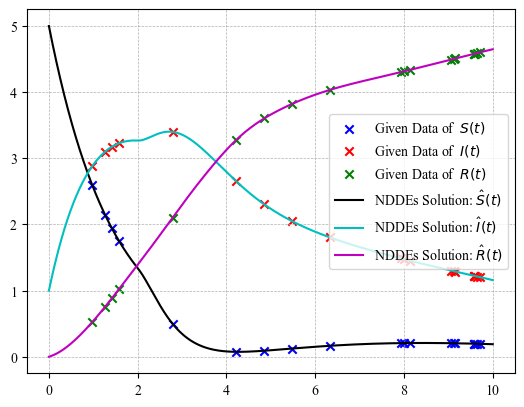

In [12]:
# Extract time points and real values from the data for three different series
t_points = init_data[:, 0]
y1_real = init_data[:, 1]
y2_real = init_data[:, 3]
y3_real = init_data[:, 5]

# Generate a set of 10,000 evenly spaced time points between tmin and tmax
T = np.linspace(tmin, tmax, 10000).reshape(-1, 1)

# Evaluate the neural network for three sets of parameters to get predictions for each set
nn_sol1 = DNNs(params[0], T)
nn_sol2 = DNNs(params[1], T)
nn_sol3 = DNNs(params[2], T)

# Set the figure size to 16 cm wide by 12 cm tall (4:3 aspect ratio)
plt.figure(figsize=(16 / 2.54, 12 / 2.54))

# Plot real and predicted values for three series using different styles and colors
plt.scatter(t_points, y1_real, label='Given Data of  $S(t)$', color='blue', marker='x')
plt.scatter(t_points, y2_real, label='Given Data of  $I(t)$', color='red', marker='x')
plt.scatter(t_points, y3_real, label='Given Data of  $R(t)$', color='green', marker='x')

plt.plot(T,nn_sol1,'k',label='NDDEs Solution: $\hat{S}(t)$')
plt.plot(T,nn_sol2,'c',label='NDDEs Solution: $\hat{I}(t)$')
plt.plot(T,nn_sol3,'m',label='NDDEs Solution: $\hat{R}(t)$')

# Add a legend with font properties
plt.legend(prop=prop)

# Set labels for the x and y axes with font properties
# plt.xlabel('$t$', fontproperties=prop)
# plt.ylabel('$Values$', fontproperties=prop)

# Customize the appearance of the axis tick labels using font properties
ax = plt.gca()
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontproperties(prop)

# Enable grid lines for major axes with specified style and line width
plt.grid(True, which='major', axis='both', linestyle='--', linewidth=0.5)

# Optionally save the figure with high resolution
save_path = os.path.join(result_save_root_path, f"Sol_ex4.4.2_N_g_{N_g}_tau_{lag_string}.png")
# save_path = os.path.join(result_save_root_path, f"Sol_ex4.4.2_N_g_3_old_tau_{lag_string}.png")
plt.savefig(save_path, dpi=600, bbox_inches='tight')

# Display the plot
# plt.show()

### Loss

In [13]:
# # Set up the figure with a specific size (converted from cm to inches)
# plt.figure(figsize=(16 / 2.54, 12 / 2.54))

# # Plot the loss history over epochs
# plt.plot(epoch_history, loss_history, 'k', label='Loss')

# # Set the y-axis to a logarithmic scale
# plt.yscale('log')

# # Add a legend with a specific font
# plt.legend(prop=prop, loc='upper right')

# # Add axis labels with the specified font
# # plt.xlabel('Epoch', fontproperties=prop)
# # plt.ylabel('Loss', fontproperties=prop)

# # Get the current axis for further customizationa
# ax = plt.gca()

# # Set font properties for tick labels on both axes
# for label in ax.get_xticklabels() + ax.get_yticklabels():
#     label.set_fontproperties(prop)

# # Add a grid to the plot with dashed lines for major ticks on both axes
# plt.grid(True, which='major', axis='both', linestyle='--', linewidth=0.5)

# # Export the plot to a file with a DPI of 600 and tight bounding box
# save_path = os.path.join(result_save_root_path, f"Loss_ex4.4.2_N_g_{N_g}_tau_{lag_string}.png")
# plt.savefig(save_path, dpi=600, bbox_inches='tight')

# # Display the plot
# # plt.show()

### Lag

In [14]:
# # Define a function to compute relative error bounds
# def relative_error_lines(real_value, error_percentage):
#     """ Calculate the lower and upper bounds of real_value considering a percentage error. """
#     lower_bound = real_value * (1 - error_percentage / 100)
#     upper_bound = real_value * (1 + error_percentage / 100)
#     return lower_bound, upper_bound, error_percentage

# params_history = jnp.stack(lag_history)

# for i in range(2):
#     lag_history = params_history[:, i]
#     loss_history_tem = loss_history

#     # Calculate error bounds for the given real_lag with a 3% error margin
#     lower_bound, upper_bound, error_percentage = relative_error_lines(config['real_lag'][i], 3)

#     # Set the figure size in a 4:3 aspect ratio
#     plt.figure(figsize=(16 / 2.54, 12 / 2.54))

#     # Plot the smoothed loss history
#     plt.plot(lag_history, loss_history_tem, 'k', label='Loss')

#     # Draw vertical lines representing the 3% error range
#     plt.axvline(x=lower_bound, color='red', linestyle='--', linewidth=1, label=f'{error_percentage}% Relative Error Line')
#     plt.axvline(x=upper_bound, color='red', linestyle='--', linewidth=1)

#     # Set the y-axis to logarithmic scale for better visualization of differences
#     plt.yscale('log')

#     # Add labels to the axes
#     # plt.xlabel(f'$\\tau_{i+1}$', fontproperties=prop)
#     # plt.ylabel('Loss', fontproperties=prop)

#     # Customize the tick labels using font properties
#     ax = plt.gca()
#     for label in ax.get_xticklabels() + ax.get_yticklabels():
#         label.set_fontproperties(prop)

#     # Add grid lines, major only, with specific style
#     plt.grid(True, which='major', axis='both', linestyle='--', linewidth=0.5)

#     # Display the legend with custom font properties
#     plt.legend(prop=prop)

#     # Save the figure with high resolution
#     save_path = os.path.join(result_save_root_path, f"Lag_{i+1}_ex4.4.2_N_g_{N_g}_tau_{lag_string}.png")
#     plt.savefig(save_path, dpi=600, bbox_inches='tight')

#     # Display the plot
#     # plt.show()